# Bayesian A/B Testing - Solving Explore vs Exploit Dilemma with Python

Lately, I have been on maternity leave and people kept saying to me "sleep when the baby sleeps" but then after surviving the first months I thought "yeah... cook when the baby cooks, develop your career when the baby develops his/her career?". Then, I have been using the short breaks my baby gives me to read a bit more about (Bayesian) A/B testing and I have taken an interesting online course:
> [Bayesian Machine Learning in Python: A/B Testing](https://www.udemy.com/course/bayesian-machine-learning-in-python-ab-testing/)

This blogpost is summarizes what I have learnt in the course.

The course introduces A/B testing in the "traditional" (frequentist) way and then discusses the Bayesian A/B testing by solving the Explore vs Exploit Dilemma. Everything is implemented in Python. In this blogpost I am not going to develop all the details. I will focus on the Explore vs Exploit Dilemma, introduce and compare the performance of the 3 algorithms shown in the course with the example of advertisement Click-Through Rate, also using Python.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Paired')
%matplotlib inline

# Set global plot parameters 
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 80

## The Example - Advertisement Click-Through Rate

This is the example developed in the course which we will also use all over to illustrate the concepts we will introduce.

Imagine you want to test the performance of 2 advertisements, say ad $A$ and ad $B$. Picture them, they look the same except for 1 feature (e.g. color/shape of the "button" linking to your page, picture displayed, text of the ad,...) which you modify with the goal to improve the proportion of users that click on the ad when they see it, i.e. the *Click-Through Rate* (CTR).

First of all, you would create a business case where you compare the "resources needed" to implement the test and the expected/desired gain, so that you evaluate whether it is worth investing time and resources (i.e. €€).

Once it is clear you want to move forward with the A/B test, you could do it the "traditional way". That means you use a sample size calculator, split your traffic (for example 50%-50% so that half of your traffic will be exposed to ad A and the other half to ad B) and let it run until you collect enough data. Then, depending on the "shape" of your data (i.e. the distribution) you will run an hypothesis test (for Bernoulli distributed data, i.e. counting data, you would go for a Chi-square test). Finally, if the p-value is less than some significance level of your choice (tipically 0.05, but sometimes also 0.01), then you reject the null hypothesis and conclude one is significantly better than the other.

I have created an example dataset by generating 1000 samples from a Bernouilli distribution with pre-fixed mean (0.51 for ad A and 0.31 for ad B), put them together in a dataframe and shuffling the rows to sort them randomly, as shown below.

In [2]:
np.random.seed(0)

N = 2000
real_mean_a = 0.51
real_mean_b = 0.31

random_ad_a = np.random.binomial(1, real_mean_a, N)
random_ad_b = np.random.binomial(1, real_mean_b, N)

ads_df = pd.DataFrame({'A': random_ad_a, 'B': random_ad_b}).melt()
ads_df.columns = ['advertisement_id', 'action']
ads_df.head()

,advertisement_id,action
0,A,0
1,A,0
2,A,0
3,A,0
4,A,1


In [3]:
# set frac = 1 to shuffle the whole set of rows
# set random_state = 1 for reproducibility
df_shuffled = ads_df.sample(frac=1, random_state = 1).reset_index(drop=True)

df_shuffled.head()

,advertisement_id,action
0,A,1
1,A,0
2,A,1
3,B,0
4,A,0


In [4]:
alg_comp_in_df = df_shuffled.copy()
ad_a = alg_comp_in_df[alg_comp_in_df['advertisement_id'] == 'A']['action'].values
ad_b = alg_comp_in_df[alg_comp_in_df['advertisement_id'] == 'B']['action'].values

A_click = sum(ad_a)
A_noclick = len(ad_a) - A_click
B_click = sum(ad_b)
B_noclick = len(ad_b) - B_click

collected_mean_a = ad_a.mean()
collected_mean_b = ad_b.mean()

print('len_a:', len(ad_a), ', A_click:', A_click, ', collected_mean_a:', collected_mean_a, ', real_mean_a:', real_mean_a)
print('len_b:', len(ad_b), ', B_click:', B_click, ', collected_mean_b:', collected_mean_b, ', real_mean_b:', real_mean_b)

len_a: 2000 , A_click: 1015 , collected_mean_a: 0.5075 , real_mean_a: 0.51
len_b: 2000 , B_click: 606 , collected_mean_b: 0.303 , real_mean_b: 0.31


Below you see an example on how one would evaluate this data in a frequentist way, using a [Chi-squared](https://en.wikipedia.org/wiki/Chi-squared_test) test. 

In [5]:
T = np.array([[A_click, A_noclick], [B_click, B_noclick]])

chi2, p, dof, expected = stats.chi2_contingency( T )
msg = 'p-value: {}'
print( msg.format(p) )

p-value: 1.9375629625827686e-39


In [6]:
if p < 0.05:
    print("Reject null hypothesis: There is statistically significant difference between the groups")
else:
    print("Cannot reject null hypothesis")

Reject null hypothesis: There is statistically significant difference between the groups


## The Explore vs Exploit Dilemma

When I was first introduced to bayesian A/B testing, we were running the tests similar to the frequentist way, i.e. letting run the test for an amount of time and afterwards using the collected data to sample from the distributions and comparing "how much better one version was over the other one".

Let us see it using the data I simulated above. The clicks follow a Bernoulli distribution which is a conjugated distribution to a Beta distribution with parameters $a = 1 + \#\rm{successes}$ and $b = 1 + \#\rm{failures}$ (see [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_discrete_distribution)).

In [7]:
# parameters beta for ad A
aA = 1 + A_click
bA = 1 + A_noclick
# parameters beta for ad B
aB = 1 + B_click
bB = 1 + B_noclick

In [8]:
M = 3000
samples_A = np.random.beta(aA, bA, M)
samples_B = np.random.beta(aB, bB, M)

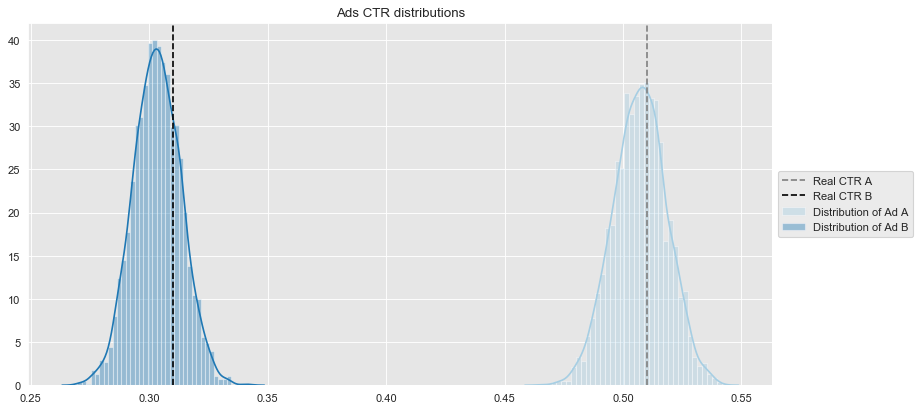

In [9]:
fig, ax = plt.subplots()
sns.distplot(a=samples_A, label='A', ax=ax)
sns.distplot(a=samples_B, label='B', ax=ax)
ax.axvline(x=real_mean_a, color='grey', linestyle='--')
ax.axvline(x=real_mean_b, color='black', linestyle='--')
plt.title('Ads CTR distributions')
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    labels=['Real CTR A', 'Real CTR B', 'Distribution of Ad A', 'Distribution of Ad B']
)
plt.savefig('plots/distributions_samples.png', dpi=200, bbox_inches='tight');

With the distributions of the CTR of the Ads it is quite evident that the ad A has performed much better than ad B. In any case one can measure "how buch better" is the performance of A with respect to B by sampling from the samples and calculating the probability that ad A is better than ad B as follows:

In [10]:
delta_A_B_sample = []
MM = 10000
for i in range(MM):
    condition = np.random.choice(samples_A) > np.random.choice(samples_B)
    delta_A_B_sample.append(condition)

print('The probability that ad A is better than ad B is', np.array(delta_A_B_sample).mean())

The probability that ad A is better than ad B is 1.0


A natural question arises:   
> If I see that ad A is performing better, can I stop my experiment and just show ad A?

To reach a point on which this question makes sense, you first need to show both advertisements (both the "good" and the "bad" ones) and analyze their performance. Eventually, you can use the information you have to show more often the ad that performs better. But how much should I show each add (**Explore**) vs should I just show the better performing ad (**Exploit**)? This is the so-called **Explore-Exploit Dilemma**.

In the [course](https://www.udemy.com/course/bayesian-machine-learning-in-python-ab-testing/), 3 different algorithms are shown to solve this problem (only the last one is Bayesian). The rest of this post is devoted to introduce these algorithms and compare their performance with the data I simulated above. First I will introduce the logic of each method and then I will illustrate them via a the simulation data generated above. 

## Solving the Explore vs Exploit Dilemma

### Strategy I: Epsilon - Greedy

The Epsilon - Greedy algorithm is an intuitive way to solve the Explore-Exploit dilemma. 

In the algorithm you choose a small number ($\epsilon$) between $0$ and $1$, which will be the probability of exploration.

```
eps = 0.1
while True:
    r = rand()
    if r < eps:
        # explore
        show random ad 
    else:
        # exploit 
        show best ad (as determined by #clicks / #impressions)
```

One issue is that even when A is significantly better than B, it will still sometimes choose B.

Let us assume we had $N$ impressions, with $\rm{reward}(\rm{Click}) = 1$, $\rm{reward}(\rm{noClick}) = 0$. 

If we consider the extreme case where A always yields a click, and B always yields 0, we have that we show ad B 50% of the times that the random number $r$ was $r < \epsilon$, i.e. the expected loss is $\epsilon N / 2$.

Hence, for $\epsilon = 0.1$, we loose $0.05N$. Nevertheless, this is still better than traditional A/B test with no adaptation, where you would loose $0.5N$.

### Strategy II: UCB1

[UCB](https://link.springer.com/content/pdf/10.1023/A:1013689704352.pdf) stands for *Upper Confidence Bound*. I have seen it several times phrased as *optimism in the face of uncertainty*. 

The main idea of the algorithm is to construct a confidence interval of what each ad’s true performance might be. Then, the algorithm selects the ad with the highest UCB. This is why "optimism", because one is assuming the ad will behave as well as its UCB. It kind of makes sense because at the end of the day we are trying to find the ad with the highest CTR.

What is this bound? The **[Chernoff-Hoeffding bound](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality)** says:
$$P(\hat\mu > \mu + \epsilon) \leq \rm{exp}(-2\epsilon^{2} N ),$$
for some $\epsilon > 0$, where $N$ denotes the number of observations (i.e. the sample size), $\hat\mu$ denotes the true CTR (mean) and $\mu$ the sample mean (i.e. the CTR of the data observed so far).

For each ad $j = A,B$, we want to pick a bound $\epsilon_j$ so that the true mean $\hat\mu_j < \mu_j + \epsilon_j$. Thus, $\rm{exp}(-2\epsilon_j^{2} N )$ should be a small probability.  
Say we set a threshold $p_j$, i.e. $p_j = \rm{exp}(-2\epsilon_j^{2} N_j )$. Then,
$$ \epsilon_j = \sqrt{-\dfrac{\log p_j}{2 N_j}}$$
and we can set $p_j = N^{-4}$ so that we obtain the epsilon:
$$\epsilon_j = \sqrt{\dfrac{2\log N}{N_j}}$$
where $N$ is the total number of ads displayed and $N_j$ the number of times that ad $j$ was displayed.

The discussion above is explained very nicely in [Lilian Weng’s blog](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#hoeffdings-inequality).

Now the algorithm is as follows:

```
N = 0
Nj = 0 for all bandits j 
while True:
    j* = argmax(mu_j + sqrt(2log(N) / Nj))

    Show ad j*
    Update mu_j*
    N++
    Nj*++
```

Let us observe closely the term `j* = argmax(mu_j + sqrt(2log(N) / Nj))`:  
- the first term is the CTR estimate (if high, we exploit more often)  
- the second term depends on $N$ and $N_j$ (so if $N$ is high, but $N_j$ is low, we are not so confident about the $CTR_j$ so we explore this more).

It can be shown that the expected loss is proportional to $\log(N)$ ([see Theorem 1 on this paper](https://link.springer.com/content/pdf/10.1023/A:1013689704352.pdf)).

Compared to the Epsilon-Greedy algorithm whose loss is proportional to $N$, in the long run UCB1 will perform much better.

### Strategy III: Bayesian

This method is also called [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling). This technique aims to perform actions to maximize the cumulative rewards.

It basically draws samples from the current posterior distribution of all the ads with the data observed so far and exploits the one giving the greatest sample value. Conceptually, we are trusting that we are exploiting the ad which will provide the highgest reward. 

Then, the algorithm reads:
```
while True:
    Draw a random sample from all ads' current Beta(aj, bj)
    j* = ad that gives us maximum sample
    x = show ad j*
    aj* = aj* + x
    bj* = bj* + 1 - x
```

In most practical applications, it can be quite computationally expensive to estimate posterior distributions using Bayesian inference, so in general this technique comes together with approximate sampling techniques. I recommend [this tutorial](https://arxiv.org/pdf/1707.02038.pdf) to learn more about thompson sampling.


### Comparison of the different strategies

In this section I have implemented and compared the 3 algorithms introduced above. 

We want to answer the following questions:  
- Which method converged to the best advertisement the fastest?  
- What is the total loss compared to what you would have gotten if you already knew which the best advertisement was and displayed only that ad every time?

The instructor of the course provided a script to simulate the process of running an http web service using `flask`, just like a real website, to treat the data generated above (and stored in a `.csv` file) like real-time data. For simplicity here I show a iterative direct implementation.   

I first define a class `Advertisement` whose attributes are its own name, the values `1/0` of `click/no click` from the input dataframe, and then a bunch of attributes with the shape `clicks_method_name` (resp. `views_method_name`) to record the clicks (resp. views/impressions) where `method_name` will be each algorithm we will be comparing:   
- `no_adapt` i.e. no adaptation, displaying random add with 50% split   
- `eps` i.e. Epsilon-Greedy algorithm   
- `ucb1` i.e. UCB1 algorithm     
- `bay` i.e. Bayesian (Thompson) algorithm  



In [11]:
class Advertisement:
    def __init__(self, name, df):
        self.name = name
        # values 1/0 of click/no click
        adv = df[df['advertisement_id'] == name]
        self.data = adv['action'].values
        # No adaptation
        self.clicks_no_adapt = 0
        self.views_no_adapt = 0
        # Epsilon-Greedy
        self.clicks_eps = 0
        self.views_eps = 0
        # UCB1
        self.clicks_ucb1 = 0
        self.views_ucb1 = 0
        # Bayesian
        self.clicks_bay = 0
        self.views_bay = 0

    def sample(self):
        # only in bayesian method
        a = 1 + self.clicks_bay
        b = 1 + self.views_bay - self.clicks_bay
        return np.random.beta(a, b)

    def add_click(self, method_name):
        if method_name == 'no_adapt':
            self.clicks_no_adapt += 1
        elif method_name == 'epsilon':
            self.clicks_eps += 1
        elif method_name == 'ucb1':
            self.clicks_ucb1 += 1
        elif method_name == 'bayesian':
            self.clicks_bay += 1

    def add_view(self, method_name):
        if method_name == 'no_adapt':
            self.views_no_adapt += 1
        elif method_name == 'epsilon':
            self.views_eps += 1
        elif method_name == 'ucb1':
            self.views_ucb1 += 1
        elif method_name == 'bayesian':
            self.views_bay += 1

Next, we need functions to act as a server request, returning the advertisement to be displayed. I create one for each method.  

In [12]:
def request_no_adapt(ads, p=0.5):
    """Returns random ad to display with split 100*p / 100-(100*p) %."""
    ad_a, ad_b = ads
    # show random ad 100*p % / 100-(100*p) %
    random_ad = np.random.binomial(1, p)
    if(random_ad == 0):
        ad = 'A'
        ad_a.add_view('no_adapt')
    else:
        ad = 'B'
        ad_b.add_view('no_adapt')

    return {'advertisement_id': ad, 'method_name': 'no_adapt'}


def request_epsilon(ads, eps=0.1):
    """Returns ad to display using Epsilon-Greedy algorithm."""
    ad_a, ad_b = ads
    # create random number between 0 and 1
    r = np.random.random()
    if r < eps or ad_a.views_eps*ad_b.views_eps == 0:
        # show random ad
        random_ad = np.random.binomial(1, 0.5)
        if(random_ad == 0):
            ad = 'A'
            ad_a.add_view('epsilon')
        else:
            ad = 'B'
            ad_b.add_view('epsilon')
    else:
        # show best add
        if ad_a.clicks_eps/ad_a.views_eps > \
                ad_b.clicks_eps/ad_b.views_eps:
            ad = 'A'
            ad_a.add_view('epsilon')
        else:
            ad = 'B'
            ad_b.add_view('epsilon')

    return {'advertisement_id': ad, 'method_name': 'epsilon'}


def request_ucb1(ads):
    """Returns ad to display using UCB1 algorithm."""
    ad_a, ad_b = ads
    cA = ad_a.clicks_ucb1
    vA = ad_a.views_ucb1
    cB = ad_b.clicks_ucb1
    vB = ad_b.views_ucb1
    if vA*vB == 0:
        # show random ad
        random_ad = np.random.binomial(1, 0.5)
        if(random_ad == 0):
            ad = 'A'
            ad_a.add_view('ucb1')
        else:
            ad = 'B'
            ad_b.add_view('ucb1')
    else:
        # calculate mu_j + eps_j for each bandit j
        # i.e. mu_j + sqrt(2ln(N) / Nj)
        jA = cA/vA + np.sqrt(2*np.log(vA + vB)/vA)
        jB = cB/vB + np.sqrt(2*np.log(vA + vB)/vB)

        # show best add
        if jA > jB:
            ad = 'A'
            ad_a.add_view('ucb1')
        else:
            ad = 'B'
            ad_b.add_view('ucb1')

    return {'advertisement_id': ad, 'method_name': 'ucb1'}


def request_bayesian(ads):
    """Returns ad to display using Bayesian (Thompson) algorithm."""
    ad_a, ad_b = ads
    sample_a = ad_a.sample()
    sample_b = ad_b.sample()
    if sample_a > sample_b:
        ad = 'A'
        ad_a.add_view('bayesian')
    else:
        ad = 'B'
        ad_b.add_view('bayesian')
    return {'advertisement_id': ad, 'method_name': 'bayesian'}


def request_ad(method_name, ads):
    """Calls request function according to method name."""
    if method_name == 'no_adapt':
        return request_no_adapt(ads, 0.5)
    elif method_name == 'epsilon':
        return request_epsilon(ads, 0.1)
    elif method_name == 'ucb1':
        return request_ucb1(ads)
    elif method_name == 'bayesian':
        return request_bayesian(ads)
    # for debugging purposes
    return 'No request method found'

We also need a function to check in our dataset whether the ad should be clicked when displayed and updates its clicks data accordingly.

In [13]:
def click_ad(method_name, ad):
    """Records click ad according to dataset input."""
    if method_name == 'no_adapt':
        views = ad.views_no_adapt
    elif method_name == 'epsilon':
        views = ad.views_eps
    elif method_name == 'ucb1':
        views = ad.views_ucb1
    elif method_name == 'bayesian':
        views = ad.views_bay

    action = ad.data[views]
    if action == 1:
        # only click the ad if our dataset determines that we should
        ad.add_click(method_name)
        return {'advertisement_id': ad.name, 'method_name': method_name}

Now we are ready to run the process. 

First, we have to initialize the variables for the ads, counts and summary list. We will need them to record the data of the advertisements and the different stats we will be interested on.

In [14]:
# initialize advertisements
ad_a = Advertisement('A', alg_comp_in_df)
ad_b = Advertisement('B', alg_comp_in_df)

count = 0

df_list = []

Then, we iterate until there is no data left for either ad for one of the methods.

In [15]:
while ad_a.views_no_adapt < N - 1 and ad_b.views_no_adapt < N - 1 and \
        ad_a.views_eps < N - 1 and ad_b.views_eps < N - 1 and \
        ad_a.views_ucb1 < N - 1 and ad_b.views_ucb1 < N - 1 and \
        ad_a.views_bay < N - 1 and ad_b.views_bay < N - 1:
    # quit when there's no data left for either ad
    # no adaptation method
    r_no_adapt = request_ad('no_adapt', (ad_a, ad_b))
    if r_no_adapt['advertisement_id'] == 'A':
        click_ad('no_adapt', ad_a)
    else:
        click_ad('no_adapt', ad_b)

    # epsilon greedy method
    r_eps = request_ad('epsilon', (ad_a, ad_b))
    if r_eps['advertisement_id'] == 'A':
        click_ad('epsilon', ad_a)
    else:
        click_ad('epsilon', ad_b)

    # ucb1 method
    r_ucb1 = request_ad('ucb1', (ad_a, ad_b))
    if r_ucb1['advertisement_id'] == 'A':
        click_ad('ucb1', ad_a)
    else:
        click_ad('ucb1', ad_b)

    # bayesian method
    r_bay = request_ad('bayesian', (ad_a, ad_b))
    if r_bay['advertisement_id'] == 'A':
        click_ad('bayesian', ad_a)
    else:
        click_ad('bayesian', ad_b)

    # log some stats
    count += 1

    df = pd.DataFrame(np.array([[count,
                                ad_a.clicks_no_adapt, ad_b.clicks_no_adapt,
                                ad_a.clicks_eps, ad_b.clicks_eps,
                                ad_a.clicks_ucb1, ad_b.clicks_ucb1,
                                ad_a.clicks_bay, ad_b.clicks_bay,
                                ad_a.views_no_adapt, ad_b.views_no_adapt,
                                ad_a.views_eps, ad_b.views_eps,
                                ad_a.views_ucb1, ad_b.views_ucb1,
                                ad_a.views_bay, ad_b.views_bay]]),
                      columns=['ad_request_num',
                               'clicksA_no_adapt', 'clicksB_no_adapt',
                               'clicksA_epsilon', 'clicksB_epsilon',
                               'clicksA_ucb1', 'clicksB_ucb1',
                               'clicksA_bayesian', 'clicksB_bayesian',
                               'viewsA_no_adapt', 'viewsB_no_adapt',
                               'viewsA_epsilon', 'viewsB_epsilon',
                               'viewsA_ucb1', 'viewsB_ucb1',
                               'viewsA_bayesian', 'viewsB_bayesian'
                               ])

    df_list.append(df)

Let us consolidate the stats we have recorded:

In [16]:
# Consolidate stats DataFrame
df_final = pd.concat(df_list, axis=0)

# Calculate CTRs for each method
# No adaptation
df_final['muA_no_adapt'] = np.where(df_final['viewsA_no_adapt'] != 0,
                                    round(df_final['clicksA_no_adapt'] /
                                    df_final['viewsA_no_adapt'], 3), 0)
df_final['muB_no_adapt'] = np.where(df_final['viewsB_no_adapt'] != 0,
                                    round(df_final['clicksB_no_adapt'] /
                                    df_final['viewsB_no_adapt'], 3), 0)

# Epsilon-Greedy algorithm
df_final['muA_epsilon'] = np.where(df_final['viewsA_epsilon'] != 0,
                               round(df_final['clicksA_epsilon'] /
                               df_final['viewsA_epsilon'], 3), 0)
df_final['muB_epsilon'] = np.where(df_final['viewsB_epsilon'] != 0,
                               round(df_final['clicksB_epsilon'] /
                               df_final['viewsB_epsilon'], 3), 0)

# UCB1 algorithm
df_final['muA_ucb1'] = np.where(df_final['viewsA_ucb1'] != 0,
                                round(df_final['clicksA_ucb1'] /
                                df_final['viewsA_ucb1'], 3), 0)
df_final['muB_ucb1'] = np.where(df_final['viewsB_ucb1'] != 0,
                                round(df_final['clicksB_ucb1'] /
                                df_final['viewsB_ucb1'], 3), 0)

# Bayesian (Thompson) algorithm
df_final['muA_bayesian'] = np.where(df_final['viewsA_bayesian'] != 0,
                                    round(df_final['clicksA_bayesian'] /
                                    df_final['viewsA_bayesian'], 3), 0)
df_final['muB_bayesian'] = np.where(df_final['viewsB_bayesian'] != 0,
                                    round(df_final['clicksB_bayesian'] /
                                    df_final['viewsB_bayesian'], 3), 0)

alg_comp_out_df = df_final.copy()

The first thing we can do is to observe the evolution of the distributions over time. For this, I have implemented a function to plot the ads distributions iteratively at a certain step.

In [17]:
def plot(df_rn, vars_data, i):
    """ Plots the ads distributions given by vars_data.
    If i>=0, it saves a .png file with iterative file name.
    """
    fig, ax = plt.subplots()
    x = np.linspace(0, 1, 200)
    for velt in vars_data:
        clicks_col, views_col, ad, method = velt
        a = 1 + df_rn[clicks_col]
        b = 1 + df_rn[views_col] - df_rn[clicks_col]
        y = stats.beta.pdf(x, a, b)
        plt.plot(x, y, label=ad + '-' + method)

    ax.axvline(x=real_mean_a, color='grey', linestyle='--', label='Real CTR A')
    ax.axvline(x=real_mean_b, color='black', linestyle='--', label='Real CTR B')
    plt.title('Ads distributions after %s views' % df_rn['ad_request_num'])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i >= 0:
        # if i >=0, save the plot in .png format
        # clean the index to get iterative filename
        index = i
        if index < 10:
            index = '0' + str(i)
        plt.savefig(f'plots/plot_ads_dist/plot_{index}.png', dpi=200, bbox_inches='tight')
    
    plt.show()

In [18]:
vars_data = [
    ['clicksA_no_adapt', 'viewsA_no_adapt', 'A', 'no_adapt'],
    ['clicksB_no_adapt', 'viewsB_no_adapt', 'B', 'no_adapt'],
    ['clicksA_epsilon', 'viewsA_epsilon', 'A', 'epsilon'],
    ['clicksB_epsilon', 'viewsB_epsilon', 'B', 'epsilon'],
    ['clicksA_ucb1', 'viewsA_ucb1', 'A', 'ucb1'],
    ['clicksB_ucb1', 'viewsB_ucb1', 'B', 'ucb1'],
    ['clicksA_bayesian', 'viewsA_bayesian', 'A', 'bayesian'],
    ['clicksB_bayesian', 'viewsB_bayesian', 'B', 'bayesian']
]

I have defined a list `plot_points` with the steps I want to plot, i.e. to plot the distributions after $x$ number of views. The code below shows how I iterate through this list to plot each step. The result is a bunch of plots that I have transformed into a `.gif` file, using `ImageMagik`, with the bash command below. I have learnt to do it on a mac from this post: [create .gif from .png files](https://stackoverflow.com/questions/20126812/mac-terminal-create-animated-gif-from-png-files).

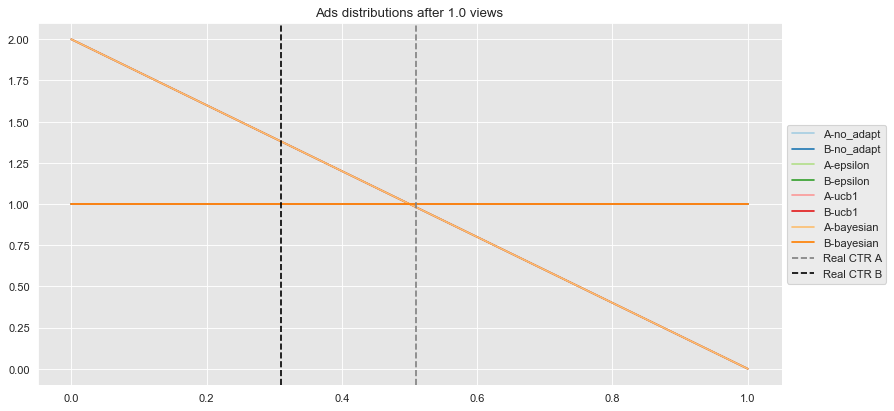

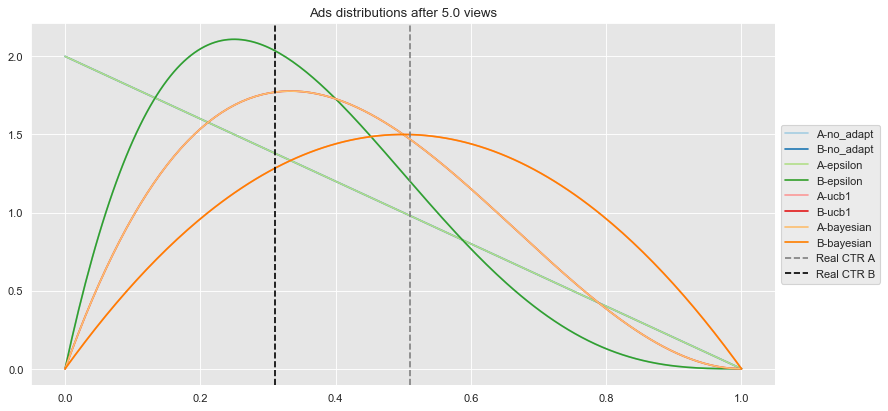

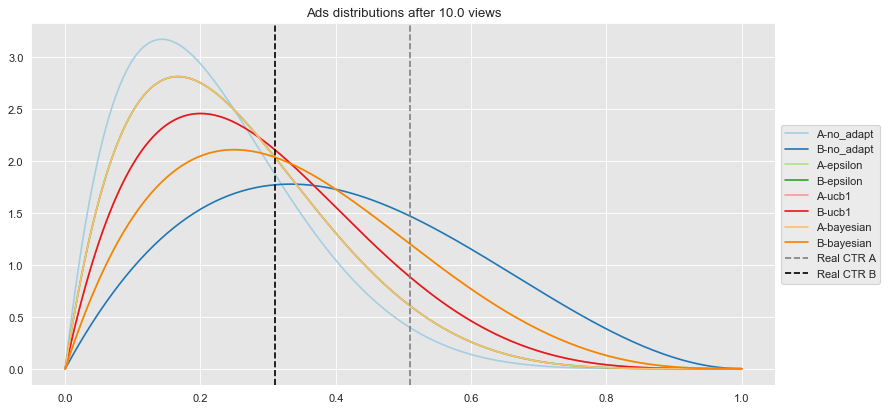

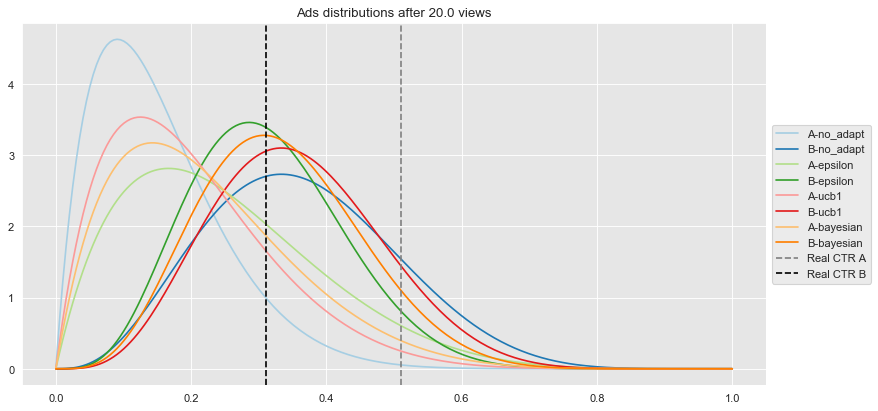

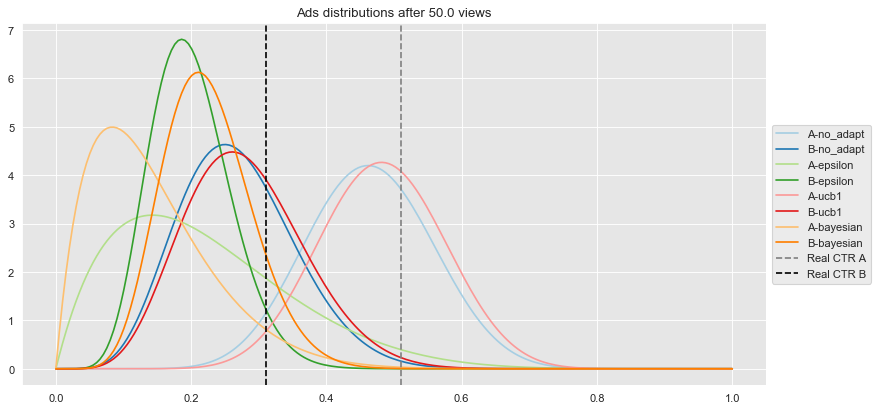

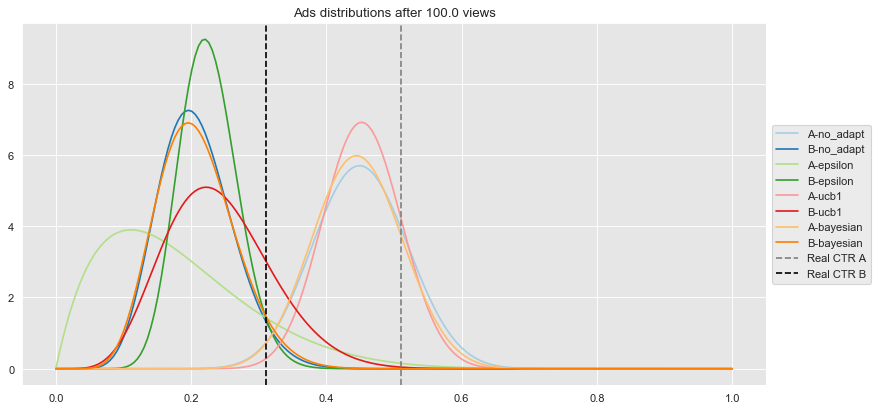

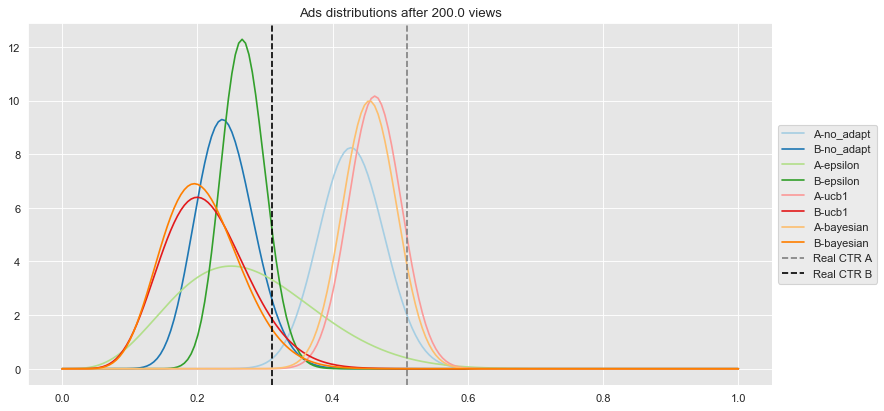

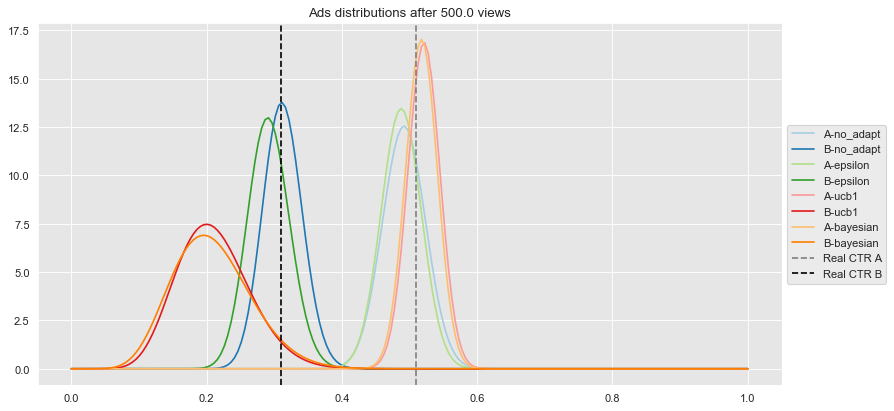

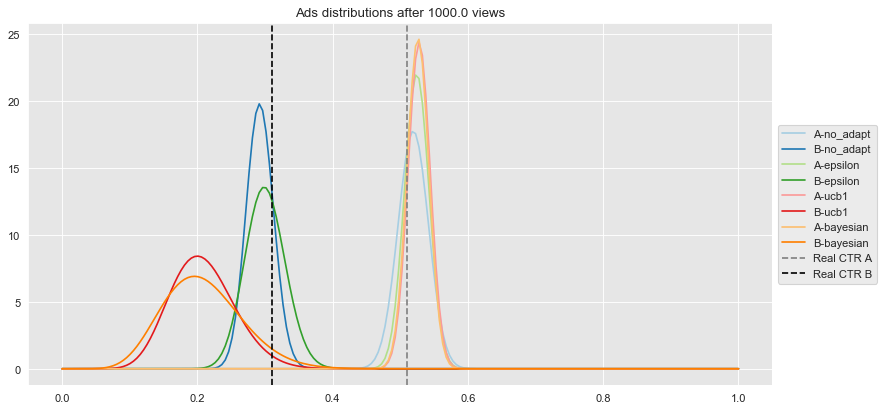

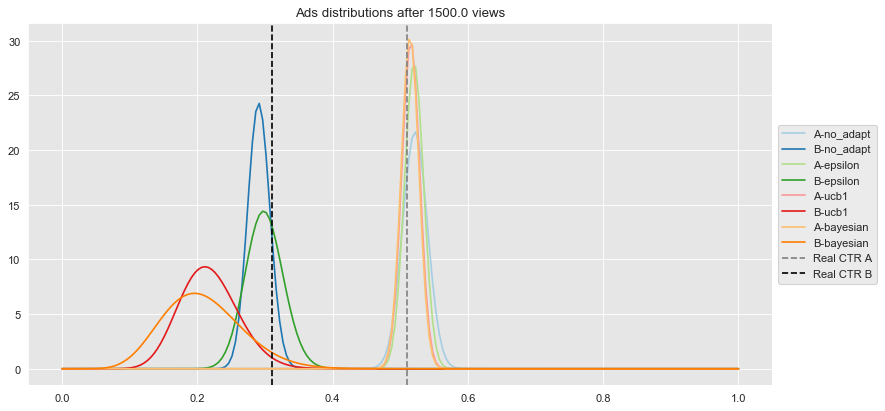

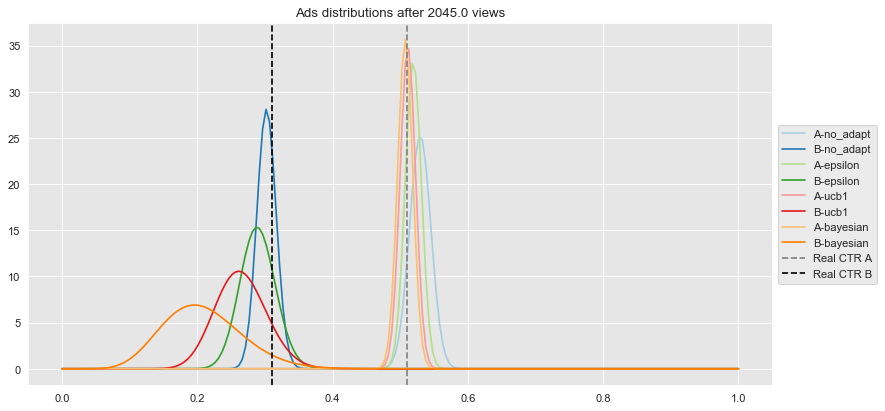

In [19]:
plot_points = [1, 5, 10, 20, 50, 100, 200, 500, 1000, 1500, alg_comp_out_df.shape[0]]
for i, plot_pt in enumerate(plot_points):
    df_rn = alg_comp_out_df.iloc[plot_pt - 1]
    plot(df_rn, vars_data, i)

In [20]:
%%bash
convert -delay 100 plots/plot_ads_dist/*.png plots/distributions.gif

We observe that:

- After 20 views, ad A sems to be underperforming in all algorithms.  
- After 50 views, it seems like ad A, with UCB1 and no adaptation are much closer to reality but with Epsilon-Greedy and Bayesian it is still underperforming.  
- After 100 views, all algorithms except Epsilon-Greedy are close to the real distribution of ad A.   
- After 500 views, all algorithms have captured the real distribution of the CTR for ad A.   
- Finally, after finishing the experiment (after 2045 views), all distributions of ad A have converged around the real CTR of A except no adaptation, which seems to be a bit higher than the rest. Here the most interesting thing is regarding ad B, where the height of its distribution is exactly as expected. Below, I sort the results from worst to best:  
    - No adaptation is the one that has explored ad B the most and therefore is closer to the real CTR of ad B.   
    - Expsilon - Greedy   
    - UCB1  
    - Bayesian (Thompson) is the one that has explored ad B the least and therefore the distribution is wider and farther from the real CTR.

As you can see, the last plot is worth observing it carefully, I include it statically below:

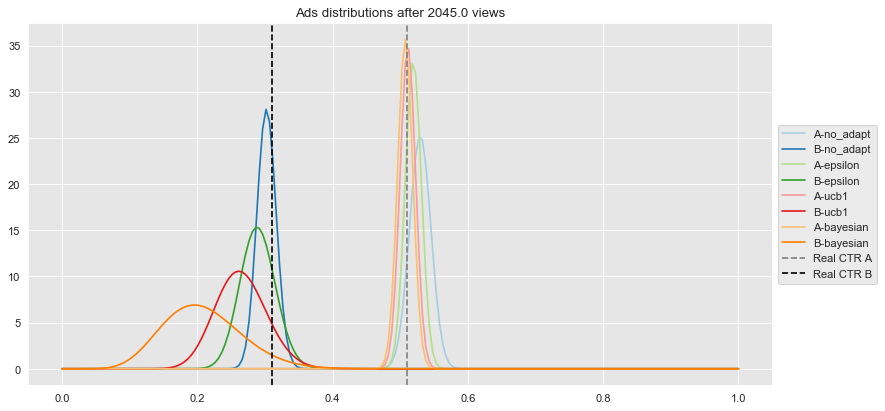

In [21]:
df_rn = alg_comp_out_df.iloc[alg_comp_out_df.shape[0] - 1]
plot(df_rn, vars_data, i=-1)

Another interesting thing to plot is the CTR (referenced as Calculated CTR) over ad request number, to see how far/close they converge to the real CTR and compare how fast is this convergence.

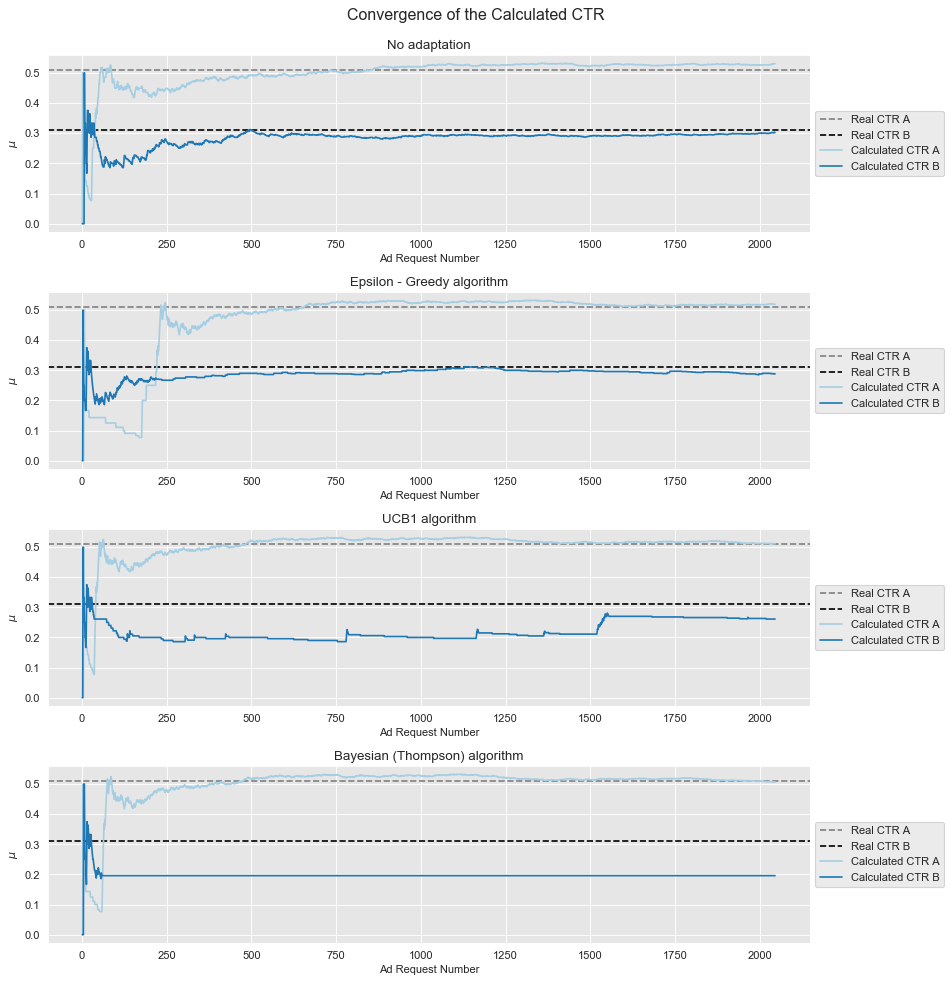

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# No adaptation
dg_eps = alg_comp_out_df \
    [['ad_request_num', 'muA_no_adapt', 'muB_no_adapt']] \
    .melt(id_vars='ad_request_num') \
    .rename(columns={'variable': 'Calculated CTR'})

ax[0].axhline(y=real_mean_a, color='grey', linestyle='--')
ax[0].axhline(y=real_mean_b, color='black', linestyle='--')
sns.lineplot(x='ad_request_num', y='value', data=dg_eps, ax=ax[0], hue='Calculated CTR')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Real CTR A', 'Real CTR B', 'Calculated CTR A', 'Calculated CTR B'])
ax[0].set(title='No adaptation', ylabel=r'$\mu$', xlabel='Ad Request Number')

# Epsilon - Greedy algorithm
dg_eps = alg_comp_out_df \
    [['ad_request_num', 'muA_epsilon', 'muB_epsilon']] \
    .melt(id_vars='ad_request_num') \
    .rename(columns={'variable': 'Calculated CTR'})

ax[1].axhline(y=real_mean_a, color='grey', linestyle='--')
ax[1].axhline(y=real_mean_b, color='black', linestyle='--')
sns.lineplot(x='ad_request_num', y='value', data=dg_eps, ax=ax[1], hue='Calculated CTR')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Real CTR A', 'Real CTR B', 'Calculated CTR A', 'Calculated CTR B'])
ax[1].set(title='Epsilon - Greedy algorithm', ylabel=r'$\mu$', xlabel='Ad Request Number')

# UCB1 algorithm
dg_ucb1 = alg_comp_out_df \
    [['ad_request_num', 'muA_ucb1', 'muB_ucb1']] \
    .melt(id_vars='ad_request_num') \
    .rename(columns={'variable': 'Calculated CTR'})

ax[2].axhline(y=real_mean_a, color='grey', linestyle='--')
ax[2].axhline(y=real_mean_b, color='black', linestyle='--')
sns.lineplot(x='ad_request_num', y='value', data=dg_ucb1, ax=ax[2], hue='Calculated CTR')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Real CTR A', 'Real CTR B', 'Calculated CTR A', 'Calculated CTR B'])
ax[2].set(title='UCB1 algorithm', ylabel=r'$\mu$', xlabel='Ad Request Number')

# Bayesian (Thompson) algorithm
dg_bayesian = alg_comp_out_df \
    [['ad_request_num', 'muA_bayesian', 'muB_bayesian']] \
    .melt(id_vars='ad_request_num') \
    .rename(columns={'variable': 'Calculated CTR'})

ax[3].axhline(y=real_mean_a, color='grey', linestyle='--')
ax[3].axhline(y=real_mean_b, color='black', linestyle='--')
sns.lineplot(x='ad_request_num', y='value', data=dg_bayesian, ax=ax[3], hue='Calculated CTR')
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['Real CTR A', 'Real CTR B', 'Calculated CTR A', 'Calculated CTR B'])
ax[3].set(title='Bayesian (Thompson) algorithm', ylabel=r'$\mu$', xlabel='Ad Request Number')

plt.suptitle('Convergence of the Calculated CTR', y=1.02, size='x-large')
plt.tight_layout()
plt.savefig('plots/convergence_ctr.png', dpi=200, bbox_inches='tight');

We observe the following:  
- No adaptation: one can clearly see that we had a random split 50%-50%, the behaviour of both ads is very similar and the CTR of both ads converge to their real one (after ca. 500 requests). For ad A in particular the convergence is farther to the real CTR compared to all the other algorithms (which agrees with what we have previously seen in the plots of the distributions).
- Epsilon-Greedy: ad A is underperforming up to ca. 200 requests and it converges to real CTR after around 500 requests. The convergence of ad B is very similar to the no adaptation method, which stresses the fact we were mentioning before, that this Epsilon-Greedy algorithm is still showing ad B quite some times.
- UCB1: while ad A converges with a speed similar to no adaptation, it does it much closer to the real CTR. On the other hand, ad B is being much less displayed, which we can see as it has a stairs shape.   
- Bayesian: convergence of ad A is very similar to UCB1 and the curve for ad B is basically flat, which seems to show that this is the method that has explored ad B the least.   

Below I include some stats for each method that validate the observations we have just seen in the plots.

In [23]:
end_result = alg_comp_out_df.iloc[- 1].copy()

In [24]:
print('Method: No Adaptation')
print('Views of A:', end_result['viewsA_no_adapt'], 
    ', Clicks on A:', end_result['clicksA_no_adapt'], 
    ', CTR:', end_result['muA_no_adapt'], 
    ', Real CTR A:', real_mean_a)
print('Views of B:', end_result['viewsB_no_adapt'], 
    ', Clicks on B:', end_result['clicksB_no_adapt'], 
    ', CTR:', end_result['muB_no_adapt'], 
    ', Real CTR B:', real_mean_b)
print('Total ads shown:', end_result['ad_request_num'], 
    ', % A shown:', round(100*end_result['viewsA_no_adapt']/end_result['ad_request_num'], 1), 
    ', % B shown:', round(100*end_result['viewsB_no_adapt']/end_result['ad_request_num'], 1))
print('Approximated number of lost clicks:', 
    round(end_result['viewsB_no_adapt']*end_result['muA_no_adapt']) - end_result['clicksB_no_adapt']
)

Method: No Adaptation
Views of A: 999.0 , Clicks on A: 529.0 , CTR: 0.53 , Real CTR A: 0.51
Views of B: 1046.0 , Clicks on B: 316.0 , CTR: 0.302 , Real CTR B: 0.31
Total ads shown: 2045.0 , % A shown: 48.9 , % B shown: 51.1
Approximated number of lost clicks: 238.0


In [25]:
print('Method: Epsilon-Greedy')
print('Views of A:', end_result['viewsA_epsilon'], 
    ', Clicks on A:', end_result['clicksA_epsilon'], 
    ', CTR:', end_result['muA_epsilon'], 
    ', Real CTR A:', real_mean_a)
print('Views of B:', end_result['viewsB_epsilon'], 
    ', Clicks on B:', end_result['clicksB_epsilon'], 
    ', CTR:', end_result['muB_epsilon'], 
    ', Real CTR B:', real_mean_b)
print('Total ads shown:', end_result['ad_request_num'], 
    ', % A shown:', round(100*end_result['viewsA_epsilon']/end_result['ad_request_num'], 1), 
    ', % B shown:', round(100*end_result['viewsB_epsilon']/end_result['ad_request_num'], 1))
print('Approximated number of lost clicks:', 
    round(end_result['viewsB_epsilon']*end_result['muA_epsilon']) - end_result['clicksB_epsilon']
)

Method: Epsilon-Greedy
Views of A: 1743.0 , Clicks on A: 905.0 , CTR: 0.519 , Real CTR A: 0.51
Views of B: 302.0 , Clicks on B: 87.0 , CTR: 0.288 , Real CTR B: 0.31
Total ads shown: 2045.0 , % A shown: 85.2 , % B shown: 14.8
Approximated number of lost clicks: 70.0


In [26]:
print('Method: UCB1')
print('Views of A:', end_result['viewsA_ucb1'], 
    ', Clicks on A:', end_result['clicksA_ucb1'], 
    ', CTR:', end_result['muA_ucb1'], 
    ', Real CTR A:', real_mean_a)
print('Views of B:', end_result['viewsB_ucb1'], 
    ', Clicks on B:', end_result['clicksB_ucb1'], 
    ', CTR:', end_result['muB_ucb1'], 
    ', Real CTR B:', real_mean_b)
print('Total ads shown:', end_result['ad_request_num'], 
    ', % A shown:', round(100*end_result['viewsA_ucb1']/end_result['ad_request_num'], 1), 
    ', % B shown:', round(100*end_result['viewsB_ucb1']/end_result['ad_request_num'], 1))
print('Approximated number of lost clicks:', 
    round(end_result['viewsB_ucb1']*end_result['muA_ucb1']) - end_result['clicksB_ucb1']
)

Method: UCB1
Views of A: 1911.0 , Clicks on A: 977.0 , CTR: 0.511 , Real CTR A: 0.51
Views of B: 134.0 , Clicks on B: 35.0 , CTR: 0.261 , Real CTR B: 0.31
Total ads shown: 2045.0 , % A shown: 93.4 , % B shown: 6.6
Approximated number of lost clicks: 33.0


In [27]:
print('Method: Bayesian')
print('Views of A:', end_result['viewsA_bayesian'], 
    ', Clicks on A:', end_result['clicksA_bayesian'], 
    ', CTR:', end_result['muA_bayesian'], 
    ', Real CTR A:', real_mean_a)
print('Views of B:', end_result['viewsB_bayesian'], 
    ', Clicks on B:', end_result['clicksB_bayesian'], 
    ', CTR:', end_result['muB_bayesian'], 
    ', Real CTR B:', real_mean_b)
print('Total ads shown:', end_result['ad_request_num'], 
    ', % A shown:', round(100*end_result['viewsA_bayesian']/end_result['ad_request_num'], 1), 
    ', % B shown:', round(100*end_result['viewsB_bayesian']/end_result['ad_request_num'], 1))
print('Approximated number of lost clicks:', 
    round(end_result['viewsB_bayesian']*end_result['muA_bayesian']) - end_result['clicksB_bayesian']
)

Method: Bayesian
Views of A: 1999.0 , Clicks on A: 1014.0 , CTR: 0.507 , Real CTR A: 0.51
Views of B: 46.0 , Clicks on B: 9.0 , CTR: 0.196 , Real CTR B: 0.31
Total ads shown: 2045.0 , % A shown: 97.8 , % B shown: 2.2
Approximated number of lost clicks: 14.0


## Final remarks

### More variants and more experiments

Note that the implementations are assuming we are experimenting with only 2 variants, but it would not be hard to generalize it to a higher number of variants. May be nice to have the code flexible to work with arbitrary number of variants. 

In any case, if one wants to experiment with other values of Real CTR's, the code is abstract enough to run all at once just by changing the values at the beginning of this post.

### More algorithms

There are more algorithms out there to deal with the Explore-Exploit Dilemma. When searching for them you can certainly find them looking for multi-bandit problems (instead of displaying ads, you play slot machines). Here I leave a link to an example of a [nice blogpost with more algorithms](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) from James LeDoux's blog.

### When can I stop gathering data for my experiment?

This is the million €€ question. The literature around this topic is really confusing and I don't want to add more confusion to your bag. This is why I am skipping this topic in this post. I personally find interesting this [post from Chris Stucchio's blog](https://www.chrisstucchio.com/blog/2014/bayesian_ab_decision_rule.html) but I need to find time to read it carefully.

### Canary releases 

A/B testing has some similarities to [Canary releases](https://martinfowler.com/bliki/CanaryRelease.html). A Canary release consists of releasing for example a new version of your software, showing it only to a fraction of your users and gradually incrementing the flow when you confirm the new version is behaving "well" (where "well" may just mean that it is stable, or maybe your goal is that conversions of some kind improve,...) so that if there is any issue, you can rollback to the old version easily. Despite its similarities, I find it is a different technique, usually for different purposes, for example:  
- Imagine you update your website from some programing language version v2.x to version 3.y. This is something you want to do because it is best practise, but don't necessarily mean you want to improve conversions or revenue (of course we would all love that but it is not the main goal of this task). In this case you would use a Canary release. 

- For A/B testing you need to set a goal, for example "improve CTR of my landing page 3%" or "reduce bounce rate 2%" and generally it is good practise to make only one change at the time yo that you can attribute the improvement to that change. 